In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
#from tqdm import tqdm_notebook
from brian2 import *

Définition des couleurs possibles pour afficher le GNW.
Fonction qui crée un identifiant de 16 caractères, lettres ou nombres, qui servira pour nommer les différentes régions.

In [2]:
COLORS = ['b', 'g', 'r', 'c', 'm', 'y', 'k', '#473C8B', '#458B74',
          '#CD7F32', '#FF4040', '#ADFF2F', '#8E2323', '#FF1493']

alphanum = np.concatenate((np.arange(48, 58), np.arange(65, 65+26)))
def name(length=16):
    return ''.join([chr(alphanum[n]) for n in np.random.randint(low=0, 
                                                                high=len(alphanum), 
                                                                size=length)])

Classe $Region$: une région est caractérisée par son nom (*cf* ci-dessus), une couleur choisie au hasard parmi celles listées ci-dessus, sa position (par défaut au centre) et ses dimensions (par défaut $1 \times 1 = 1$ colonne).    

In [3]:
class Region():
    def __init__(self, nam=None, siz=[1,1], pos=[0,0], col=None):
        if nam==None:
            self.nam = name()
        else:
            self.nam = nam

        if col==None:
            self.col = COLORS[np.random.randint(len(COLORS))]
        else:
            self.col = col
            
        self.siz = siz
        self.pos = pos

On s'intéresse ici à 4 aires: deux aires plutôt chargées de récupérer l'information, un noyau (Kernel) qui l'aggrège et la traite et une zone chargée de produire le comportement. Les paramètres correspondant à ces aires. Par exemple la zone Kernel se situe au centre, et contient $2 \times 2 = 4$ colonnes. 

In [4]:
areas = ["Input1",
         "Input2",
         "Kernel",
         "Output"]

In [5]:
config = {"Input1": {'siz': (1,1), 'pos': (-5., 0.), 'col': 'r'},
          "Input2": {'siz': (1,1), 'pos': (+5., 0.), 'col': 'g'},
          "Kernel": {'siz': (2,2), 'pos': (0., 0.), 'col': 'b'},
          "Output": {'siz': (1,1), 'pos': (0., +5.), 'col': 'k'}}

Ici il s'agit tout d'abord de définir plus précisement ce qu'il se passe dans les différentes aires. Les aires sont constituées de colonnes corticales, ces colonnes sont composées chacune  de 100 neurones, qui peuvent être *excitateurs* (en nombre $N_E$) ou *inhibiteurs* (en nombre $N_I$), qui peuvent appartenir aux couches corticales $1$ et $2$, ou à la couche $4$.

L'idée est elle de ne pas parler juste ici des neurones pyramidaux qui modélisent des projections plus lointaines et ne sont donc pris pas pris en compte comme neurones sein d'une colonne mais plutôt dans la matrice des connections entre ces colonnes (*cf*  ci-dessous) ? 
Cela expliquerait de ne pas traiter les couches $3$ (pyramidale externe) et $5$ (pyramidale interne) et de n'évoquer que les couches $1$, $2$, et $4$ à cet endroit précis.

On fixe en suite les constantes de temps pour:
* les canaux ioniques activés par le glutamate (et l'agoniste AMPA)
* les canaux ioniques inhibiteurs activés par l'acide gammma-aminobutyrique
* la plasticité fonction du temps d'occurrence des impulsions
(je ne suis pas encore à l'aise avec les modeles STDP mais je vais regarder ça).

Ensuite on décrit la matrice d'adjacence du graphe des connections entre les différentes aires.

In [6]:
# Defining model parameters
simtime = 30*second # Simulation time
column_size = 100
input_size = 0.2 * column_size
output_size = 0.2 * column_size

NE = int(0.8 * column_size)
NI = int(0.2 * column_size)
N12 = int(0.3 * column_size)
N4 = int(0.7 * column_size)

tau_ampa = 5.0*ms   # Glutamatergic synaptic time constant
tau_gaba = 10.0*ms  # GABAergic synaptic time constant
tau_stdp = 20*ms    # STDP time constant

epsilon = 0.5      # Sparseness of synaptic connections

gconn = {
    "Input1": {
        "Input1": 1.0 * epsilon,
        "Input2": 0.0 * epsilon,
        "Kernel": 0.8 * epsilon,
        "Output": 0.0 * epsilon,
    },
    "Input2": {
        "Input1": 0.0 * epsilon,
        "Input2": 1.0 * epsilon,
        "Kernel": 0.8 * epsilon,
        "Output": 0.0 * epsilon,
    },
    "Kernel": {
        "Input1": 0.3 * epsilon,
        "Input2": 0.3 * epsilon,
        "Kernel": 1.0 * epsilon,
        "Output": 0.8 * epsilon,
    },
    "Output": {
        "Input1": 0.0 * epsilon,
        "Input2": 0.0 * epsilon,
        "Kernel": 0.3 * epsilon,
        "Output": 1.0 * epsilon,
    }
}




Ensuite on parcoure l'ensemble des aires: pour chaque aire on cree une instance de la classe $Region$, avec les paramètres indiqués dans le tableau $config$ mentionné plus haut. Puis on parcoure les colonnes d'une région donnée (à part pour Kernel, il n'y a donc dans l'exemple présent qu'une colonne à regarder), et on définit pour chaque colonne le type, la position (distribuée aléatoirement autour de la position de la colonne), la couche et d'autres paramètres de ses neurones. Ces données sur les neurones sont collectées dans les tableaux $neurons$ _ $gnw$,$neurons$ _ $hcc$,  $neurons$ _ $typ$, $neurons$ _ $col$, $neurons$ _ $lay$, $neurons$ _ $pos$ _ $x$, $neurons$ _ $pos$ _ $y$, ... Puis on affiche les neurones, et ensuite les connections entre régions.

Input1 <—0.5—> Input1
Input1 <—0.0—> Input2
Input1 <—0.4—> Kernel
Input1 <—0.0—> Output
Input2 <—0.0—> Input1
Input2 <—0.5—> Input2
Input2 <—0.4—> Kernel
Input2 <—0.0—> Output
Kernel <—0.15—> Input1
Kernel <—0.15—> Input2
Kernel <—0.5—> Kernel
Kernel <—0.4—> Output
Output <—0.0—> Input1
Output <—0.0—> Input2
Output <—0.15—> Kernel
Output <—0.5—> Output


<Figure size 432x288 with 0 Axes>

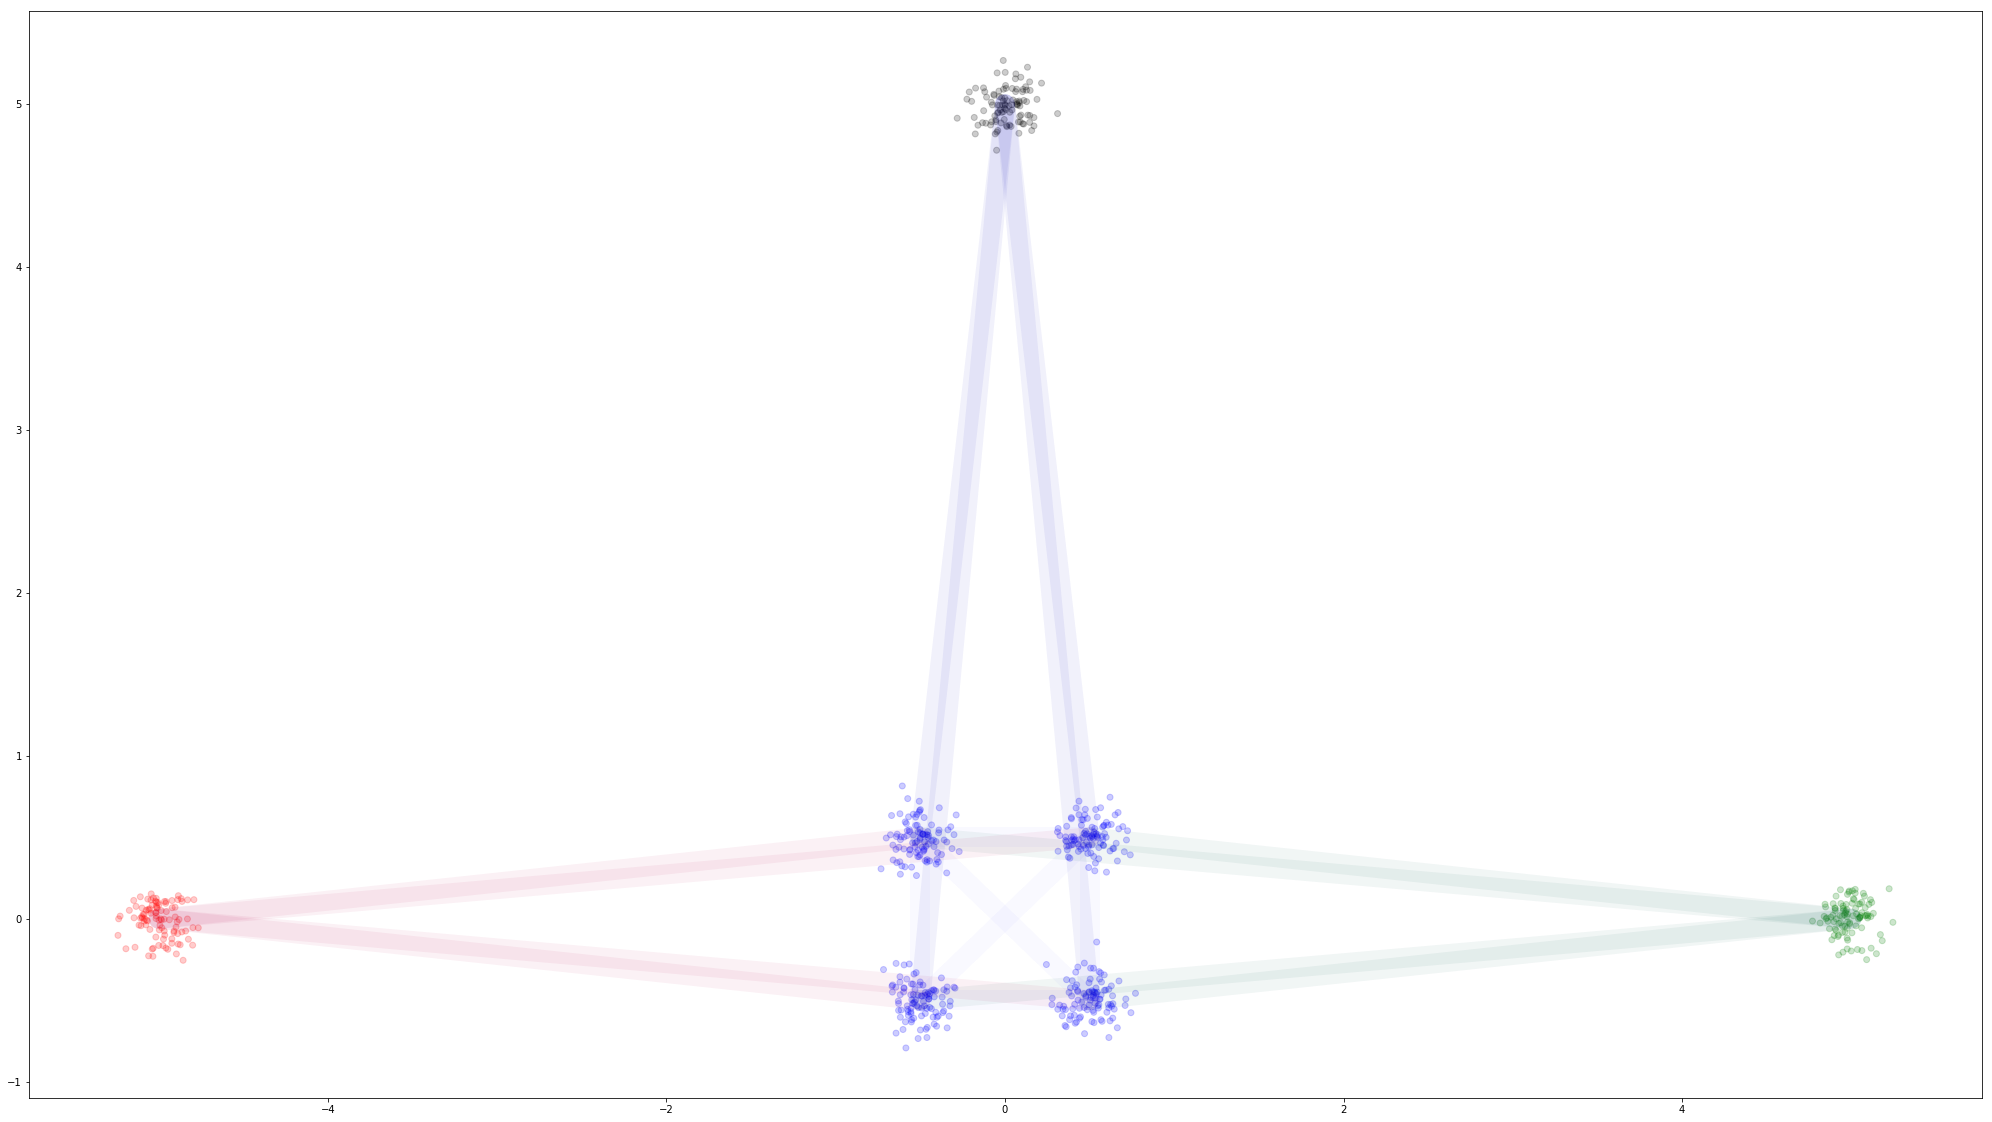

In [7]:


brain = []
neurons_num = 0
neurons_gnw = []
neurons_typ = []
neurons_col = []
neurons_hcc = []
neurons_lay = []
neurons_pos_x = []
neurons_pos_y = []

plt.figure()
for area_idx, area in enumerate(areas):
    region = Region(nam=area, siz=config[area]['siz'], pos=config[area]['pos'], col=config[area]['col'])
    brain.append(region)
    column_idx = 0
    x0, y0 = region.pos
    for x1 in np.arange(-region.siz[0]/2., region.siz[0]/2.):
        for y1 in np.arange(-region.siz[1]/2., region.siz[1]/2.):
            # plt.scatter(x0+x1+0.5, y0+y1+0.5, color=region.col)
            column_idx = column_idx + 1
            neurons_num = neurons_num + (NE+NI)
            neurons_gnw.append([area] * (NE+NI))
            neurons_hcc.append([column_idx] * (NE+NI))
            neurons_typ.append(['E']*NE + ['I']*NI)
            neurons_col.append([config[area]['col']] * (NE+NI))
            neurons_lay.append(['1/2'] * N12 + ['4'] * N4)
            neurons_pos_x.append((x0+x1+0.5) + np.random.randn(NE+NI)/10)
            neurons_pos_y.append((y0+y1+0.5) + np.random.randn(NE+NI)/10)

neurons_gnw = np.array(neurons_gnw).flatten()
neurons_hcc = np.array(neurons_hcc).flatten()
neurons_typ = np.array(neurons_typ).flatten()
neurons_col = np.array(neurons_col).flatten()
neurons_lay = np.array(neurons_lay).flatten()
neurons_pos_x = np.array(neurons_pos_x).flatten()
neurons_pos_y = np.array(neurons_pos_y).flatten()

plt.figure(figsize=[35,20])
plt.scatter(neurons_pos_x, neurons_pos_y, c=neurons_col, alpha=0.2)

for region1 in brain:
    for region2 in brain:
        print("{} <—{}—> {}".format(region1.nam, gconn[region1.nam][region2.nam], region2.nam))
        x01, y01 = region1.pos
        for x1 in np.arange(-region1.siz[0]/2., region1.siz[0]/2.):
            for y1 in np.arange(-region1.siz[1]/2., region1.siz[1]/2.):
                x02, y02 = region2.pos
                for x2 in np.arange(-region2.siz[0]/2., region2.siz[0]/2.):
                    for y2 in np.arange(-region2.siz[1]/2., region2.siz[1]/2.):
                        if region1.nam == region2.nam:
                            regularizer = epsilon/(1. + np.sqrt((x2-x1)**2 + (y2-y1)**2))
                        else:
                            regularizer = 1.
                        plt.plot([x01+x1+0.5, x02+x2+0.5],
                                 [y01+y1+0.5, y02+y2+0.5],
                                 color=region1.col,
                                 linewidth=20,
                                 alpha=(gconn[region1.nam][region2.nam]) * regularizer / 10,
                                 solid_capstyle='round')
plt.show()

Maintenant il s'agit de préciser ce que font les neurones qu'on a défini plus haut. On initialise tout d'abord leurs paramètres principaux: conductivité du canal ionique de fuite (ions $CL^-$), potentiel de repos aux bornes de la membrane, potentiel d'équilibre des canaux ioniques synaptiques pour les neurones inhibiteurs (potentiel d'équilibre des canaux ioniques synaptiques pour les neurones excitateurs est souvent pris égal à $0$), capacité de la membrane considérée comme condensateur.

Puis les équations différentielles suivies par:
* le potentiel de la membrane, établie avec la loi des noeuds
* les conductances des canaux ioniques synaptiques (activés par les neurotransmetteurs et leurs agonistes plus que par les changements de polarisation de la membrane)

Puis des équations plus précises pour les synapses: modélisation de la Spike Time Dependent Plasticity, *cf* https://brian2.readthedocs.io/en/stable/resources/tutorials/2-intro-to-brian-synapses.html#more-complex-synapse-models-stdp . L'idée est que le poids des connections synaptiques change selon la règle Hebbienne: "Neurons that fire together wire together".

In [8]:
# Neuron model

gl = 10.0*nsiemens   # Leak conductance
el = -60*mV          # Resting potential
er = -80*mV          # Inhibitory reversal potential
vt = -50.*mV         # Spiking threshold
memc = 200.0*pfarad  # Membrane capacitance
bgcurrent = 200*pA   # External current

eqs_neurons='''
x : meter
y : meter
dv/dt=(-gl*(v-el)-(g_ampa*v+g_gaba*(v-er))+bgcurrent)/memc : volt (unless refractory)
dg_ampa/dt = -g_ampa/tau_ampa : siemens
dg_gaba/dt = -g_gaba/tau_gaba : siemens
'''


# Synapse model
eqs_stdp_inhib = '''
w : 1
dApre/dt=-Apre/tau_stdp : 1 (event-driven)
dApost/dt=-Apost/tau_stdp : 1 (event-driven)
'''

eqs_stdp_exc = '''
w : 1
dApre/dt = -Apre/tau_stdp : 1 (event-driven)
dApost/dt = -Apost/tau_stdp : 1 (event-driven)'''

alpha_s = 4*Hz*tau_stdp*2  # Target rate parameter
gmax = 100               # Maximum inhibitory weight

On utilise la classe Brian $Network$ (https://brian2.readthedocs.io/en/stable/reference/brian2.core.network.Network.html) pour étudier le réseau que forment l'ensemble des $neurons$ __ $num$ neurones de notre $GNW$.  

En particulier l'idée est de définir les synapses inhibiteur-inhibiteur, excitateur-excitateur, et excitateur-inhibiteur

In [9]:
network = Network()

# Initialize neuron group
neurons = NeuronGroup(neurons_num, model=eqs_neurons, threshold='v > vt',
                      reset='v=el', refractory=5*ms, method='euler')
network.add(neurons)
neurons.x = neurons_pos_x * umeter
neurons.y = neurons_pos_y * umeter

con_e = []
con_ii = []
con_ie = []

for region in brain:
    hccs = np.argwhere(neurons_gnw == region.nam)
    hccs_idx = neurons_hcc[hccs].flatten()
    hccs_num = np.unique(hccs_idx)
    for hcc in hccs_num:
        hcc_idx = hccs[np.argwhere(hccs_idx == hcc).flatten()].flatten()
        nstart = hcc_idx[0]
        nend = hcc_idx[-1]
        con_e.append(Synapses(neurons[nstart:(nstart+NE)], neurons[nstart:nend], on_pre='g_ampa += 0.3*nS'))
        con_e[-1].connect(p=epsilon)
        con_ii.append(Synapses(neurons[(nstart+NE):nend], neurons[(nstart+NE):nend], on_pre='g_gaba += 3*nS'))
        con_ii[-1].connect(p=epsilon)
        # Inhibitory Plasticity
        con_ie.append(Synapses(neurons[(nstart+NE):nend], neurons[nstart:(nstart+NE)], model=eqs_stdp_inhib,
                               on_pre='''Apre += 1.
                                      w = clip(w+(Apost-alpha_s)*eta, 0, gmax)
                                      g_gaba += w*nS''',
                               on_post='''Apost += 1.
                                       w = clip(w+Apre*eta, 0, gmax)
                                    '''))
        con_ie[-1].connect(p=epsilon)
        con_ie[-1].w = 1e-10
        network.add(con_e[-1])
        network.add(con_ii[-1])
        network.add(con_ie[-1])

WARNING    Cannot use Cython, a test compilation failed: Cython is not available (ImportError) [brian2.codegen.runtime.cython_rt.cython_rt.failed_compile_test]
INFO       Cannot use compiled code, falling back to the numpy code generation target. Note that this will likely be slower than using compiled code. Set the code generation to numpy manually to avoid this message:
prefs.codegen.target = "numpy" [brian2.devices.device.codegen_fallback]


On (re ?) définit les connections synaptiques entre différentess zones, mais en utilisant la classe $NeuronGroup$ ce qui permet de s'intéresser au potentiel de membrane des différents neurones des trois régions: input1, input2, et result/output. Pas encore bien compris. 

In [10]:
alpha=0.9

input1 = NeuronGroup(input_size, 'rates: Hz', threshold='rand()<rates*dt')
input2 = NeuronGroup(input_size, 'rates: Hz', threshold='rand()<rates*dt')
result = NeuronGroup(output_size, 'rates: Hz', threshold='rand()<rates*dt')
network.add(input1)
network.add(input2)
network.add(result)

hccs2 = np.argwhere(neurons_gnw == 'Input1')
hccs_idx2 = neurons_hcc[hccs2].flatten()
hccs_num2 = np.unique(hccs_idx2)
for hcc2 in hccs_num2:
    hcc_idx2 = hccs2[np.argwhere(hccs_idx2 == hcc2).flatten()].flatten()
    nstart2 = hcc_idx2[0]
    nend2 = hcc_idx2[-1]
    S1 = Synapses(input1, neurons[(nstart2+N12):(nstart2+NE)], 'w : volt', on_pre='v_post += w')
    S1.connect()
    S1.w = 1e-3 * volt
    network.add(S1)

hccs2 = np.argwhere(neurons_gnw == 'Input2')
hccs_idx2 = neurons_hcc[hccs2].flatten()
hccs_num2 = np.unique(hccs_idx2)
for hcc2 in hccs_num2:
    hcc_idx2 = hccs2[np.argwhere(hccs_idx2 == hcc2).flatten()].flatten()
    nstart2 = hcc_idx2[0]
    nend2 = hcc_idx2[-1]
    S2 = Synapses(input2, neurons[(nstart2+N12):(nstart2+NE)], 'w : volt', on_pre='v_post += w')
    S2.connect()
    S2.w = 1e-3 * volt
    network.add(S2)

hccs2 = np.argwhere(neurons_gnw == 'Output')
hccs_idx2 = neurons_hcc[hccs2].flatten()
hccs_num2 = np.unique(hccs_idx2)
for hcc2 in hccs_num2:
    hcc_idx2 = hccs2[np.argwhere(hccs_idx2 == hcc2).flatten()].flatten()
    nstart2 = hcc_idx2[0]
    nend2 = hcc_idx2[-1]
    S3 = Synapses(result, neurons[(nstart2+N12):(nstart2+NE)], 'w : volt', on_pre='v_post += w')
    S3.connect()
    S3.w = 1e-3 * volt
    network.add(S3)

M1 = SpikeMonitor(input1)
M2 = SpikeMonitor(input2)
O = SpikeMonitor(result)
network.add(M1)
network.add(M2)
network.add(O)

input1.rates = 40 * Hz * (1-alpha)
input2.rates = 40 * Hz * (1-alpha)
result.rates = 40 * Hz * (1-alpha)

In [11]:
sm = SpikeMonitor(neurons)

# without plasticity at all
eta = 0          # Learning rate intra-columnar
eta_cc = 0       # Learning rate inter-columnar
network.add(sm)
network.run(1*second)

# with intra-columnar plasticity only
eta = 1e-1       # Learning rate intra-columnar
eta_cc = 0       # Learning rate inter-columnar
network.run(simtime-1*second, report='text')

WARNING    c:\users\valentin\appdata\local\programs\python\python37-32\lib\site-packages\sympy\matrices\matrices.py:2479: SymPyDeprecationWarning: 

Dot product of non row/column vectors has been deprecated since SymPy
1.2. Use * to take matrix products instead. See
https://github.com/sympy/sympy/issues/13815 for more info.

  useinstead="* to take matrix products").warn()
 [py.warnings]


Starting simulation at t=1. s for a duration of 29. s
0.77372 (2%) simulated in 10s, estimated 6m 5s remaining.
1.684416666666667 (5%) simulated in 20s, estimated 5m 24s remaining.
2.6252733333333333 (9%) simulated in 30s, estimated 5m 1s remaining.
3.5728000000000004 (12%) simulated in 40s, estimated 4m 45s remaining.
4.53647 (15%) simulated in 50s, estimated 4m 30s remaining.
5.497143333333334 (18%) simulated in 1m 0s, estimated 4m 17s remaining.
6.464196666666667 (22%) simulated in 1m 10s, estimated 4m 4s remaining.
7.425933333333333 (25%) simulated in 1m 20s, estimated 3m 52s remaining.
8.419666666666668 (29%) simulated in 1m 30s, estimated 3m 40s remaining.
9.398223333333334 (32%) simulated in 1m 40s, estimated 3m 29s remaining.
10.377166666666668 (35%) simulated in 1m 50s, estimated 3m 17s remaining.
11.348666666666668 (39%) simulated in 2m 0s, estimated 3m 7s remaining.
12.319973333333335 (42%) simulated in 2m 10s, estimated 2m 56s remaining.
13.29099 (45%) simulated in 2m 20s, 

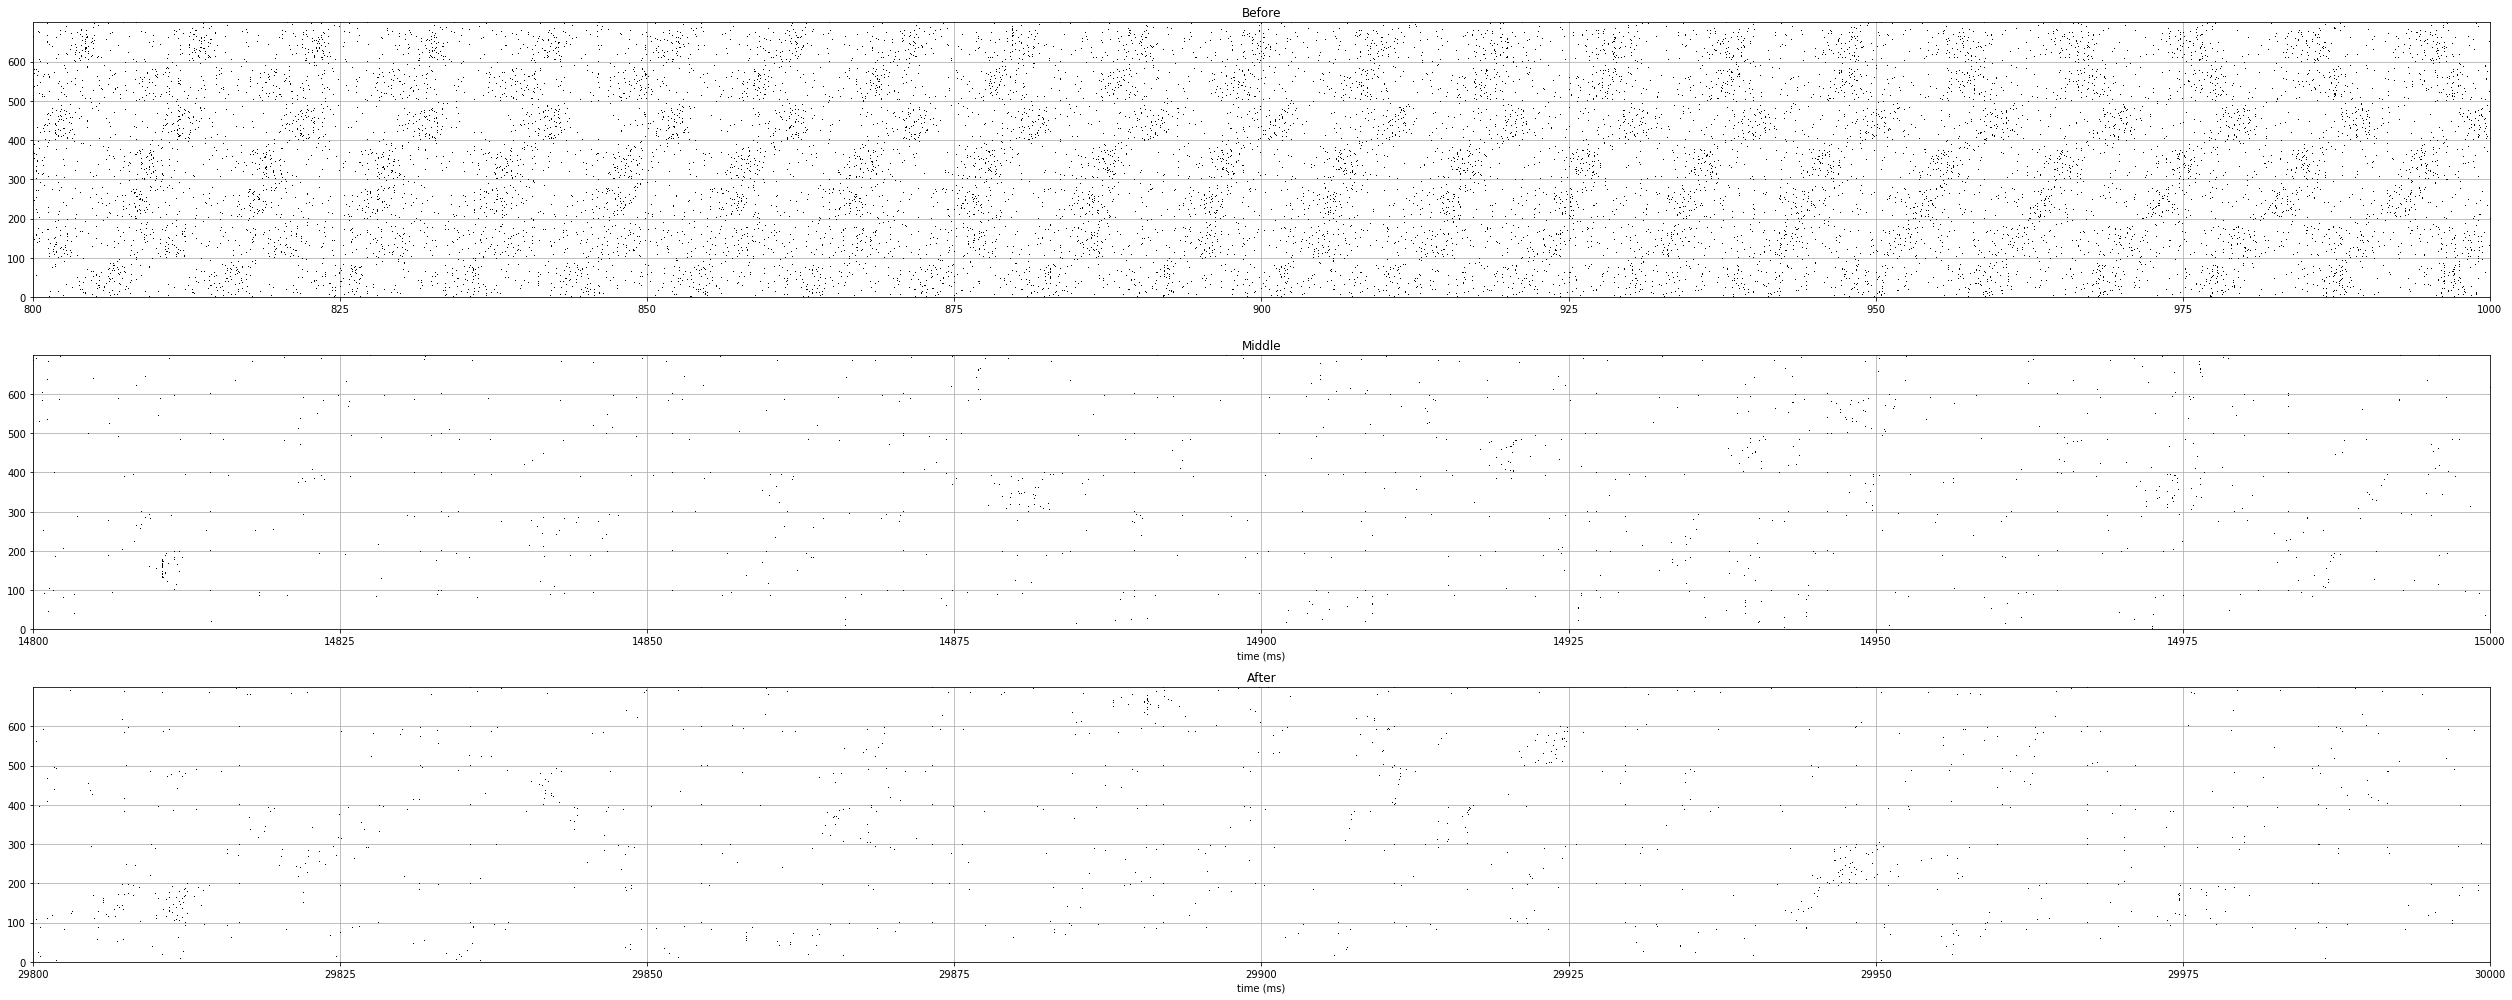

In [12]:
plt.figure(figsize=[35, 14])
i, t = sm.it
subplot(311)
plot(t/ms, i, ',k', ms=0.25)
title("Before")
xlabel("")
yticks([])
xlim(0.8*1e3, 1*1e3)
ylim(0, neurons_num)
plt.yticks(np.arange(0, neurons_num, column_size))
plt.grid(True)

subplot(312)
plot(t/ms, i, ',k', ms=0.25)
xlabel("time (ms)")
yticks([])
title("Middle")
xlim((simtime/2-0.2*second)/ms, simtime/2/ms)
ylim(0, neurons_num)
plt.yticks(np.arange(0, neurons_num, column_size))
plt.grid(True)

subplot(313)
plot(t/ms, i, ',k', ms=0.25)
xlabel("time (ms)")
yticks([])
title("After")
xlim((simtime-0.2*second)/ms, simtime/ms)
ylim(0, neurons_num)
plt.yticks(np.arange(0, neurons_num, column_size))
plt.grid(True)


plt.tight_layout()
show()

In [13]:
con_cc = []
for region1 in brain:
    hccs1 = np.argwhere(neurons_gnw == region1.nam)
    hccs_idx1 = neurons_hcc[hccs1].flatten()
    hccs_num1 = np.unique(hccs_idx1)
    for hcc1 in hccs_num1:
        hcc_idx1 = hccs1[np.argwhere(hccs_idx1 == hcc1).flatten()].flatten()
        nstart1 = hcc_idx1[0]
        nend1 = hcc_idx1[-1]
        for region2 in brain:
            hccs2 = np.argwhere(neurons_gnw == region2.nam)
            hccs_idx2 = neurons_hcc[hccs2].flatten()
            hccs_num2 = np.unique(hccs_idx2)
            for hcc2 in hccs_num2:
                hcc_idx2 = hccs2[np.argwhere(hccs_idx2 == hcc2).flatten()].flatten()
                nstart2 = hcc_idx2[0]
                nend2 = hcc_idx2[-1]
                
                if (region1.nam == region2.nam) and (hcc1 == hcc2):
                    break
                connectivity = gconn[region1.nam][region2.nam]
                print("{} - HCC {} <--{}--> {} - HCC {}".format(region1.nam, hcc1, connectivity, region2.nam, hcc2))
                d = np.sqrt((neurons_pos_x[hccs2].flatten().mean() - neurons_pos_x[hccs1].flatten().mean())**2 +
                            (neurons_pos_y[hccs2].flatten().mean() - neurons_pos_y[hccs1].flatten().mean())**2)

                con_cc.append(Synapses(neurons[nstart1:(nstart1+N12)], neurons[(nstart2+N12):(nstart2+NE)], model=eqs_stdp_exc,        
                                       on_pre='''Apre += 1.
                                              w = clip(w+(Apost-alpha_s)*eta_cc, 0, gmax)
                                              g_ampa += w*nS''',
                                       on_post='''Apost += 1.
                                               w = clip(w+Apre*eta_cc, 0, gmax)
                                               ''',
                                       delay=d*ms))

                con_cc[-1].connect(p=connectivity)
                network.add(con_cc[-1])
        print('\n')

Input1 - HCC 1 <--0.0--> Input2 - HCC 1
Input1 - HCC 1 <--0.4--> Kernel - HCC 1
Input1 - HCC 1 <--0.4--> Kernel - HCC 2
Input1 - HCC 1 <--0.4--> Kernel - HCC 3
Input1 - HCC 1 <--0.4--> Kernel - HCC 4
Input1 - HCC 1 <--0.0--> Output - HCC 1


Input2 - HCC 1 <--0.0--> Input1 - HCC 1
Input2 - HCC 1 <--0.4--> Kernel - HCC 1
Input2 - HCC 1 <--0.4--> Kernel - HCC 2
Input2 - HCC 1 <--0.4--> Kernel - HCC 3
Input2 - HCC 1 <--0.4--> Kernel - HCC 4
Input2 - HCC 1 <--0.0--> Output - HCC 1


Kernel - HCC 1 <--0.15--> Input1 - HCC 1
Kernel - HCC 1 <--0.15--> Input2 - HCC 1
Kernel - HCC 1 <--0.4--> Output - HCC 1


Kernel - HCC 2 <--0.15--> Input1 - HCC 1
Kernel - HCC 2 <--0.15--> Input2 - HCC 1
Kernel - HCC 2 <--0.5--> Kernel - HCC 1
Kernel - HCC 2 <--0.4--> Output - HCC 1


Kernel - HCC 3 <--0.15--> Input1 - HCC 1
Kernel - HCC 3 <--0.15--> Input2 - HCC 1
Kernel - HCC 3 <--0.5--> Kernel - HCC 1
Kernel - HCC 3 <--0.5--> Kernel - HCC 2
Kernel - HCC 3 <--0.4--> Output - HCC 1


Kernel - HCC 4 <--0.15--

In [14]:
# with intra-columnar plasticity only
eta = 1e-1       # Learning rate intra-columnar
eta_cc = 0       # Learning rate inter-columnar
network.run(1*second)
# with both intra-columnar & inter-columnar plasticity
eta = 1e-1       # Learning rate intra-columnar
eta_cc = 1e-1       # Learning rate inter-columnar
network.run(simtime-1*second, report='text')

WARNING    c:\users\valentin\appdata\local\programs\python\python37-32\lib\site-packages\sympy\matrices\matrices.py:2479: SymPyDeprecationWarning: 

Dot product of non row/column vectors has been deprecated since SymPy
1.2. Use * to take matrix products instead. See
https://github.com/sympy/sympy/issues/13815 for more info.

  useinstead="* to take matrix products").warn()
 [py.warnings]


Starting simulation at t=31. s for a duration of 29. s
0.21861166666666718 (0%) simulated in 10s, estimated 21m 57s remaining.
0.45046666666666774 (1%) simulated in 20s, estimated 21m 8s remaining.
0.680340000000001 (2%) simulated in 30s, estimated 20m 49s remaining.
0.904075 (3%) simulated in 40s, estimated 20m 43s remaining.
1.1190616666666668 (3%) simulated in 50s, estimated 20m 46s remaining.
1.3338550000000011 (4%) simulated in 1m 0s, estimated 20m 45s remaining.
1.5485033333333338 (5%) simulated in 1m 10s, estimated 20m 41s remaining.
1.7617016666666665 (6%) simulated in 1m 20s, estimated 20m 37s remaining.
1.9862100000000003 (6%) simulated in 1m 30s, estimated 20m 24s remaining.
2.2146816666666687 (7%) simulated in 1m 40s, estimated 20m 10s remaining.
2.438271666666666 (8%) simulated in 1m 50s, estimated 19m 58s remaining.
2.6553850000000017 (9%) simulated in 2m 0s, estimated 19m 51s remaining.
2.8717250000000023 (9%) simulated in 2m 10s, estimated 19m 43s remaining.
3.085793333

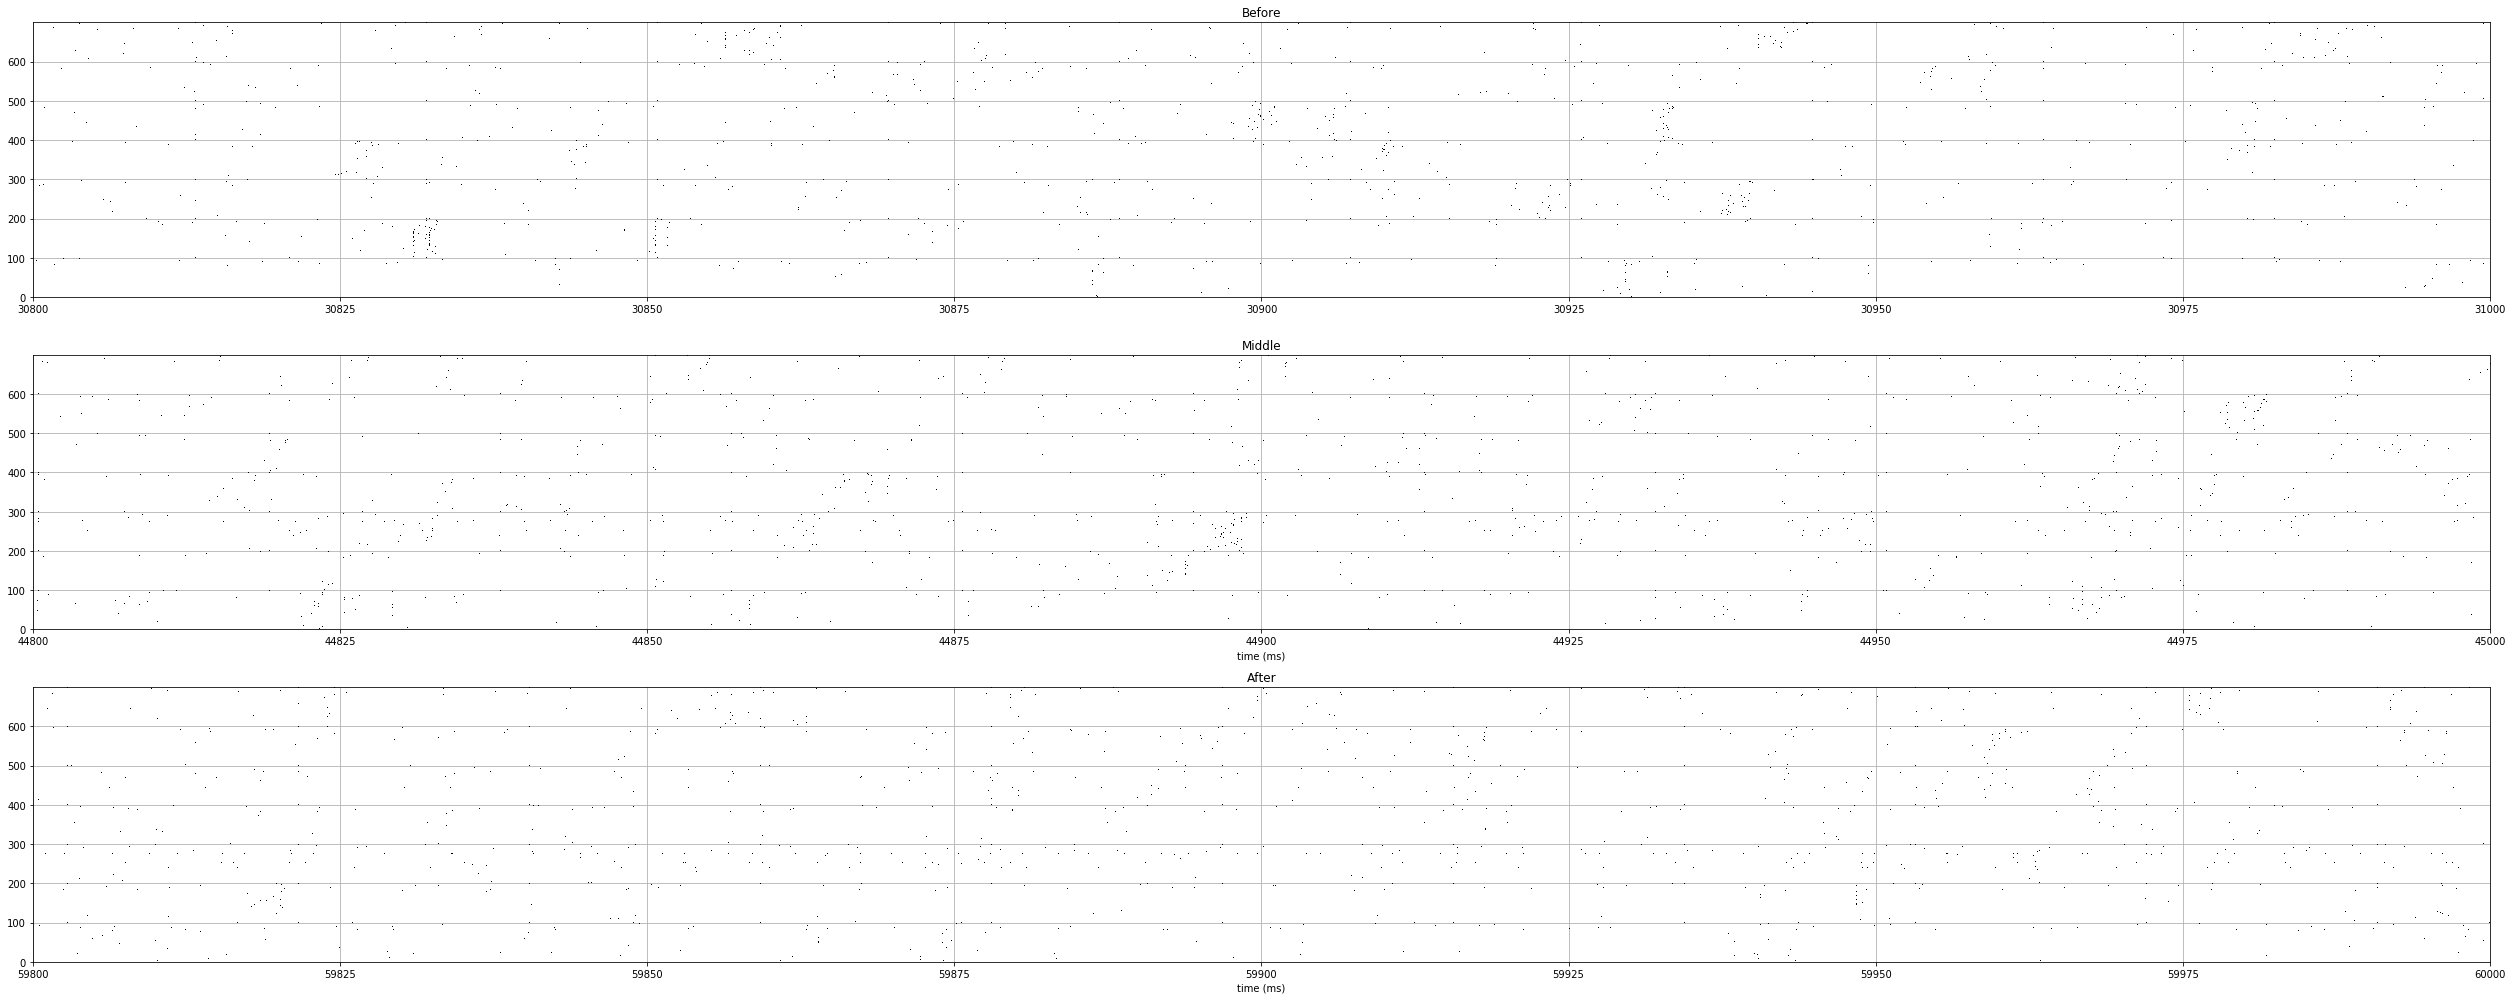

In [15]:
plt.figure(figsize=[35, 14])
i, t = sm.it

subplot(311)
plot(t/ms, i, ',k', ms=0.25)
title("Before")
xlabel("")
yticks([])
xlim((simtime + 0.8*second)/ms, simtime/ms + 1*1e3)
ylim(0, neurons_num)
plt.yticks(np.arange(0, neurons_num, column_size))
plt.grid(True)

subplot(312)
plot(t/ms, i, ',k', ms=0.25)
xlabel("time (ms)")
yticks([])
title("Middle")
xlim((3/2*simtime - 0.2*second)/ms, 3/2*simtime/ms)
ylim(0, neurons_num)
plt.yticks(np.arange(0, neurons_num, column_size))
plt.grid(True)

subplot(313)
plot(t/ms, i, ',k', ms=0.25)
xlabel("time (ms)")
yticks([])
title("After")
xlim((2*simtime - 0.2*second)/ms, 2 * simtime/ms)
ylim(0, neurons_num)
plt.yticks(np.arange(0, neurons_num, column_size))
plt.grid(True)


plt.tight_layout()
show()

In [ ]:
# with both intra-columnar & inter-columnar plasticity
eta = 1e-1       # Learning rate intra-columnar
eta_cc = 1e-1       # Learning rate inter-columnar
network.run(1*second)
# with inter-columnar plasticity only
eta = 1e-1       # Learning rate intra-columnar
eta_cc = 1e-1       # Learning rate inter-columnar
network.run(simtime-1*second, report='text')

In [ ]:
plt.figure(figsize=[35, 14])
i, t = sm.it

subplot(311)
plot(t/ms, i, ',k', ms=0.25)
title("Before")
xlabel("")
yticks([])
xlim((2*simtime + 0.8*second)/ms, 2*simtime/ms + 1*1e3)
ylim(0, neurons_num)
plt.yticks(np.arange(0, neurons_num, column_size))
plt.grid(True)

subplot(312)
plot(t/ms, i, ',k', ms=0.25)
xlabel("time (ms)")
yticks([])
title("Middle")
xlim((5/2*simtime - 0.2*second)/ms, 5/2*simtime/ms)
ylim(0, neurons_num)
plt.yticks(np.arange(0, neurons_num, column_size))
plt.grid(True)

subplot(313)
plot(t/ms, i, ',k', ms=0.25)
xlabel("time (ms)")
yticks([])
title("After")
xlim((3*simtime - 0.2*second)/ms, 3 * simtime/ms)
ylim(0, neurons_num)
plt.yticks(np.arange(0, neurons_num, column_size))
plt.grid(True)


plt.tight_layout()
show()

In [ ]:
figure(figsize=[35,7*2])
plot(t/ms, i, ',b', ms=0.25)
xlabel("time (ms)")
yticks([])
title("Global")
plt.plot([0*simtime/ms, 0*simtime/ms], [0, neurons_num], '--k', linewidth=5)
plt.plot([1*simtime/ms, 1*simtime/ms], [0, neurons_num], '--k', linewidth=5)
plt.plot([2*simtime/ms, 2*simtime/ms], [0, neurons_num], '--k', linewidth=5)
plt.plot([0*simtime/ms + 1000, 0*simtime/ms + 1000], [0, neurons_num], 'r', linewidth=2)
plt.plot([1*simtime/ms + 1000, 1*simtime/ms + 1000], [0, neurons_num], 'r', linewidth=2)
plt.plot([2*simtime/ms + 1000, 2*simtime/ms + 1000], [0, neurons_num], 'r', linewidth=2)

for column in range(7):
    plt.plot([0, 3*simtime/ms], [column*column_size+NE, column*column_size+NE], 'grey', linewidth=3)
    plt.plot([0, 3*simtime/ms], [column*column_size+N12, column*column_size+N12], 'grey', linewidth=3)

xlim(0, 3*simtime/ms)
ylim(0, neurons_num)

plt.yticks(np.arange(0, neurons_num, column_size))
plt.grid(True, linestyle='-', linewidth=3, color='k')
plt.tight_layout()
show()

In [ ]:
figure(figsize=[35,7*2])
plot(t/ms, i, ',b', ms=0.25)
xlabel("time (ms)")
yticks([])
title("Global")
plt.plot([0*simtime/ms, 0*simtime/ms], [0, neurons_num], '--k', linewidth=5)
plt.plot([1*simtime/ms, 1*simtime/ms], [0, neurons_num], '--k', linewidth=5)
plt.plot([2*simtime/ms, 2*simtime/ms], [0, neurons_num], '--k', linewidth=5)
plt.plot([3*simtime/ms, 3*simtime/ms], [0, neurons_num], '--k', linewidth=5)
plt.plot([0*simtime/ms + 1000, 0*simtime/ms + 1000], [0, neurons_num], 'r', linewidth=2)
plt.plot([1*simtime/ms + 1000, 1*simtime/ms + 1000], [0, neurons_num], 'r', linewidth=2)
plt.plot([2*simtime/ms + 1000, 2*simtime/ms + 1000], [0, neurons_num], 'r', linewidth=2)
plt.plot([3*simtime/ms + 1000, 3*simtime/ms + 1000], [0, neurons_num], 'g', linewidth=2)

for column in range(7):
    plt.plot([0, 3*simtime/ms], [column*column_size+NE, column*column_size+NE], 'grey', linewidth=3)
    plt.plot([0, 3*simtime/ms], [column*column_size+N12, column*column_size+N12], 'grey', linewidth=3)

xlim(3*simtime/ms-1000, 3*simtime/ms)
ylim(0, neurons_num)

plt.yticks(np.arange(0, neurons_num, column_size))
plt.grid(True, linestyle='-', linewidth=3, color='k')
plt.tight_layout()
show()

figure(figsize=[35,3])
plot(M1.t/ms, M1.i, '.r', markersize=1)
plot(M2.t/ms, input_size+M2.i, '.g', markersize=1)
plot(O.t/ms, input_size+output_size+O.i, '.k', markersize=1)
xlim(3*simtime/ms-1000, 3*simtime/ms)
plt.tight_layout()
show()

In [ ]:
in1 = []
in2 = []
out = []
for stim in tqdm_notebook(range(int(simtime/4/second))):
    value1 = np.random.randint(low=0, high=2)
    value2 = np.random.randint(low=0, high=2)
    in1.append(value1)
    in2.append(value2)
    out.append(value1 != value2)
    
    input1.rates = 40 * Hz * (alpha * value1 + (1-alpha))
    input2.rates = 40 * Hz * (alpha * value2 + (1-alpha))
    if (value1 != value2):
        result.rates = 40 * Hz * alpha
    else:
        result.rates = 40 * Hz * (1-alpha)
    network.run(3*second)

    input1.rates = 40 * Hz * (1-alpha)
    input2.rates = 40 * Hz * (1-alpha)  
    result.rates = 40 * Hz * (1-alpha)
    network.run(1*second)

In [ ]:
figure(figsize=[35,7*2])
plot(t/ms, i, ',b', ms=0.25)
xlabel("time (ms)")
yticks([])
title("Global")
plt.plot([0*simtime/ms, 0*simtime/ms], [0, neurons_num], '--k', linewidth=5)
plt.plot([1*simtime/ms, 1*simtime/ms], [0, neurons_num], '--k', linewidth=5)
plt.plot([2*simtime/ms, 2*simtime/ms], [0, neurons_num], '--k', linewidth=5)
plt.plot([3*simtime/ms, 3*simtime/ms], [0, neurons_num], '--k', linewidth=5)
plt.plot([0*simtime/ms + 1000, 0*simtime/ms + 1000], [0, neurons_num], 'r', linewidth=2)
plt.plot([1*simtime/ms + 1000, 1*simtime/ms + 1000], [0, neurons_num], 'r', linewidth=2)
plt.plot([2*simtime/ms + 1000, 2*simtime/ms + 1000], [0, neurons_num], 'r', linewidth=2)
plt.plot([3*simtime/ms + 1000, 3*simtime/ms + 1000], [0, neurons_num], 'g', linewidth=2)

for column in range(7):
    plt.plot([0, 3*simtime/ms], [column*column_size+NE, column*column_size+NE], 'grey', linewidth=3)
    plt.plot([0, 3*simtime/ms], [column*column_size+N12, column*column_size+N12], 'grey', linewidth=3)

xlim(3*simtime/ms, 4*simtime/ms)
ylim(0, neurons_num)

plt.yticks(np.arange(0, neurons_num, column_size))
plt.grid(True, linestyle='-', linewidth=3, color='k')
plt.tight_layout()
show()

figure(figsize=[35,3])
plot(M1.t/ms, M1.i, '.r', markersize=1)
plot(M2.t/ms, input_size+M2.i, '.g', markersize=1)
plot(O.t/ms, input_size+output_size+O.i, '.k', markersize=1)
xlim(3*simtime/ms, 4*simtime/ms)
plt.tight_layout()
show()

In [ ]:
figure(figsize=[35,7*2])

tmin = 4*simtime/ms-10000
tmax = tmin + 10000

sel = np.argwhere((t/ms >= tmin) * (t/ms <= tmax))

plot(t[sel]/ms, i[sel], '.b', markersize=2)
xlabel("time (ms)")
yticks([])
title("Global")
plt.plot([0*simtime/ms, 0*simtime/ms], [0, neurons_num], '--k', linewidth=5)
plt.plot([1*simtime/ms, 1*simtime/ms], [0, neurons_num], '--k', linewidth=5)
plt.plot([2*simtime/ms, 2*simtime/ms], [0, neurons_num], '--k', linewidth=5)
plt.plot([3*simtime/ms, 3*simtime/ms], [0, neurons_num], '--k', linewidth=5)
plt.plot([0*simtime/ms + 1000, 0*simtime/ms + 1000], [0, neurons_num], 'r', linewidth=2)
plt.plot([1*simtime/ms + 1000, 1*simtime/ms + 1000], [0, neurons_num], 'r', linewidth=2)
plt.plot([2*simtime/ms + 1000, 2*simtime/ms + 1000], [0, neurons_num], 'r', linewidth=2)
plt.plot([3*simtime/ms + 1000, 3*simtime/ms + 1000], [0, neurons_num], 'g', linewidth=2)

for column in range(7):
    plt.plot([0, 3*simtime/ms], [column*column_size+NE, column*column_size+NE], 'grey', linewidth=3)
    plt.plot([0, 3*simtime/ms], [column*column_size+N12, column*column_size+N12], 'grey', linewidth=3)

xlim(tmin, tmax)
ylim(0, neurons_num)

plt.yticks(np.arange(0, neurons_num, column_size))
plt.grid(True, linestyle='-', linewidth=3, color='k')
plt.tight_layout()
show()

figure(figsize=[35,3])
plot(M1.t/ms, M1.i, '.r', markersize=2)
plot(M2.t/ms, input_size+M2.i, '.g', markersize=2)
plot(O.t/ms, input_size+output_size+O.i, '.k', markersize=2)
xlim(tmin, tmax)
plt.tight_layout()
show()